In [18]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pygam import LinearGAM
plt.rcParams['figure.figsize'] = [18, 10]
plt.style.use('ggplot')
mpl.rcParams['axes.color_cycle'] = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854'] #from http://colorbrewer2.org

/Users/Asia/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


## Loading data


In [2]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')
data.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Chosen columns:
     pphhsize - Household Size
     relate_duration_at_w6_years - july 2017-year and month when rel started
     w6_friend_connect_4 - partner knows my friends and I know my partner's friends before metting
     w6_otherdate - In the past year, have you ever met someone for dating, for romance, or for sex
     S1 - Are you married? (output)

### Dropping rows, which had nulls and changing categorical data

In [3]:
data = data[['pphhsize', 'relate_duration_at_w6_years', 'w6_friend_connect_4', 'w6_otherdate', 'S1']].dropna()
data['pphhsize'] = data['pphhsize'].astype(float)
data = pd.get_dummies(data)

#### Rows with an answer *Refused* in *w6_otherdate* also admitted as null

In [4]:
data = data.loc[data['w6_otherdate_Refused'] == 0] 
data.drop('w6_otherdate_Refused', axis=1, inplace=True)

#### Renaming columns and splitting for train and test

In [5]:
data.rename(columns={'relate_duration_at_w6_years': 'relate_duration',
            'w6_friend_connect_4_Yes': 'friends_connect',
            'w6_otherdate_Yes, I have met at least one person for dating, romance, or sex besides [Partner Name] in  the past year.': 'otherdate',
            'S1_Yes, I am Married':'married'},
            inplace=True)
#fixed otherdate column, which was opposite value in previous notebooks
data = data.reset_index()
data = data[['pphhsize', 'relate_duration', 'friends_connect', 'otherdate', 'married']]

X_data, y_data = data[['pphhsize', 'relate_duration', 'friends_connect', 'otherdate']], data[['married']]
y_data = np.array(y_data).ravel()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

### Training model

In [6]:
cls = RandomForestClassifier(n_estimators=500)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
y_pred_proba = cls.predict_proba(X_train)[:,1]

### Accuracy

In [7]:
accuracy_score(y_pred, y_test)

0.8195050946142649

### Residuals and model response

In [19]:
res = y_train - y_pred_proba
gam = LinearGAM()
gam.fit(y_pred_proba, res)
grid = gam.generate_X_grid(term=0, n=200)

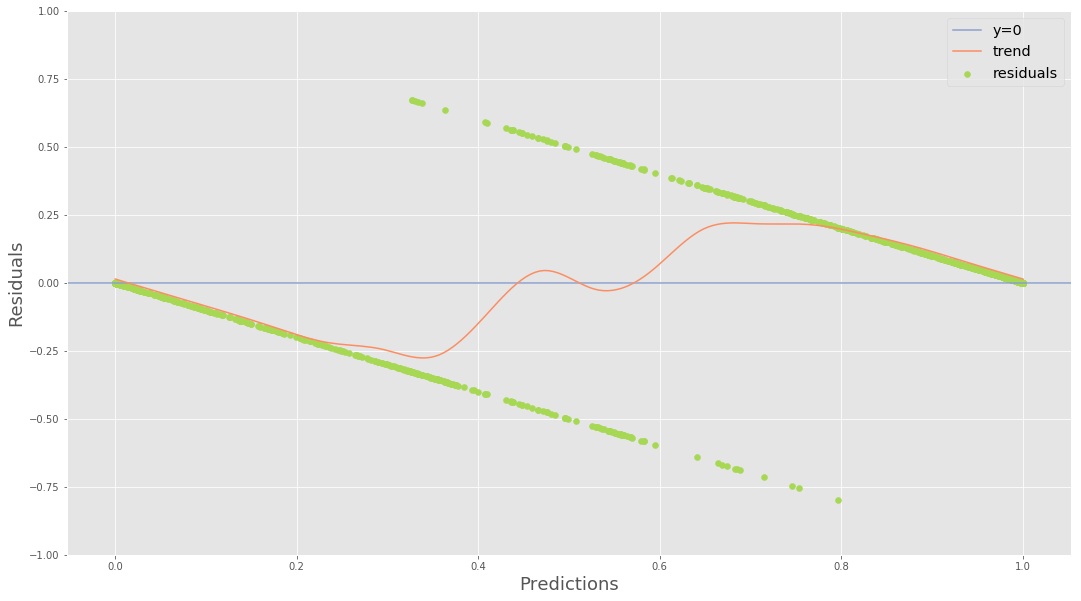

In [20]:
plt.axhline(y=0, color='#8da0cb', label='y=0')
plt.scatter(x=y_pred_proba, y=res, color='#a6d854', label="residuals")
plt.plot(grid, gam.partial_dependence(term=0, X=grid), color='#fc8d62', label="trend")
plt.legend(fontsize='x-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.ylim(-1,1)
plt.show()

#### Przedstawiono zależność reszt od predykcji razem z linią trendu. Linia trendu oscyluje wokół y=0 z pewnymi zaburzeniami. Ze względu na zagadnienie klasyfikacji, reszty ułożone są w dwie równoległe proste.

### Residuals and one label

In [21]:
res = y_train - y_pred_proba
gam = LinearGAM()
gam.fit(X_train['pphhsize'], res)
grid = gam.generate_X_grid(term=0, n=200)

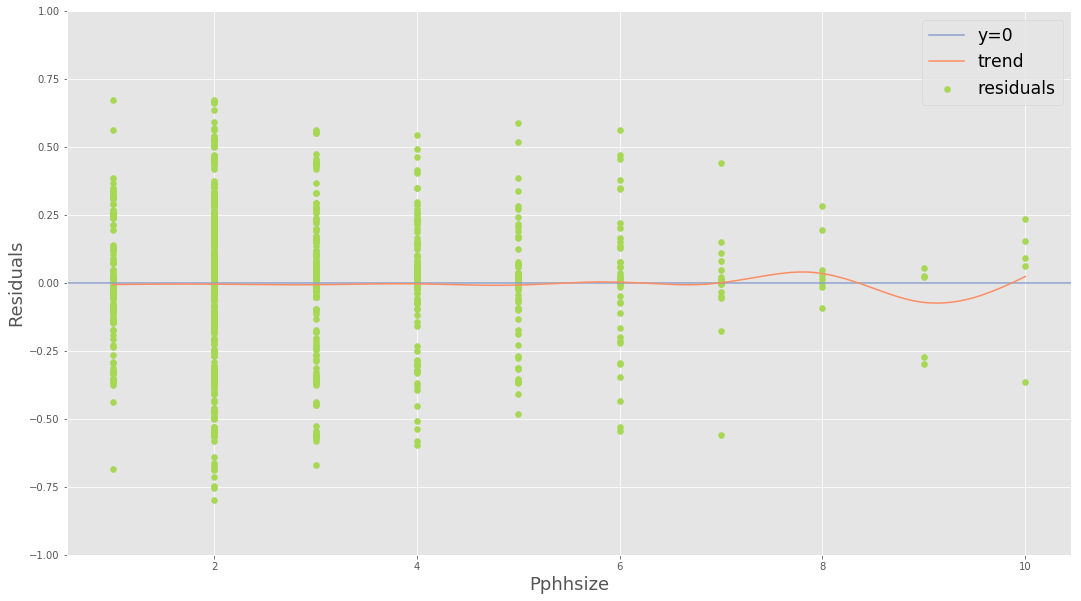

In [22]:
plt.scatter(x=X_train['pphhsize'], y=res, label="residuals", color='#a6d854')
plt.axhline(y=0, color='#8da0cb', label='y=0')
plt.plot(grid, gam.partial_dependence(term=0, X=grid), label="trend",  color='#fc8d62')
plt.legend(fontsize='xx-large')
plt.xlabel('Pphhsize', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.ylim(-1,1)
plt.show()

#### Przedstawiono zależność reszt od ilości domowników razem z linią trendu. Linia trendu jest zbliżona do y=0 (z zaburzeniami przy większej ilości domowników, gdzie danych było mniej). Reszty dla każdej wartości są bardzo różne.

### Cook's distance

In [12]:
def cooks_distance():
    cls_temp = RandomForestClassifier(n_estimators=500)
    cooks = []
    X_train.reset_index(inplace=True, drop=True)
    i = 0
    for index, row in X_train.iterrows():
        i += 1
        if i % 100 == 0:
            print(f'Done: {i}')
        X_temp = X_train.drop(index=index)
        y_temp = np.delete(y_train, index)
        cls_temp.fit(X_temp, y_temp)
        cooks.append(np.mean((cls_temp.predict_proba(X_temp)[:,1] - cls.predict_proba(X_temp)[:,1])**2))
    return cooks

In [13]:
cooks = cooks_distance()

Done: 100
Done: 200
Done: 300
Done: 400
Done: 500
Done: 600
Done: 700
Done: 800
Done: 900
Done: 1000
Done: 1100
Done: 1200
Done: 1300
Done: 1400
Done: 1500
Done: 1600
Done: 1700
Done: 1800
Done: 1900
Done: 2000


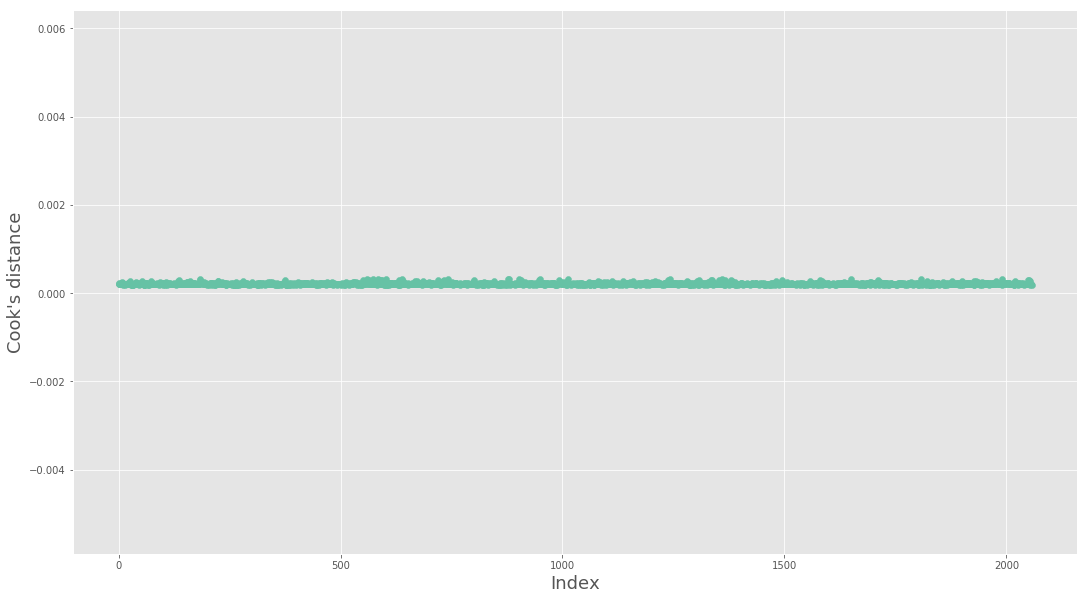

In [26]:
plt.scatter(np.arange(X_train.shape[0]), cooks)
plt.ylabel("Cook's distance", fontsize=18)
plt.xlabel("Index", fontsize=18)
plt.show()

#### Ze względu na charakterystykę modelu drzewiastego wartości Cook'a są bardzo niskie.